## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2023-01-06 14:30:12--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.003s  

2023-01-06 14:30:12 (34.5 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = ''.join(text).lower()

# Your great code here

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [2]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

--2023-01-03 16:24:28--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2023-01-03 16:24:28 (8.12 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.
# text = ''.join(text).lower()

# Your great code here

# assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
# assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
# print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
# Your great code here
token_to_idx = {char: index for index, char in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
idx_to_token = {index: char for index, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

In [7]:
def to_matrix(text, max_len, batch_size):
    """Casts a list of texts into rnn-digestable matrix"""
    
    text_idx = random.sample(range(len(text) - max_len), batch_size)

    text_batch = []
    for idx in text_idx:
      text_batch.append([token_to_idx[c] for c in text[idx:idx + max_len]])

    return np.array(text_batch)

In [8]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [9]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [18]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb.to(device), h_prev.to(device)], dim=-1) #YOUR CODE HERE
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) #YOUR CODE HERE
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [11]:
hyperparams = {
    'depth': 11,
    'length': 24
}

In [12]:
num_tokens = len(tokens)

In [19]:
char_rnn = CharRNNCell().to(device)

In [20]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [63]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss()

history = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

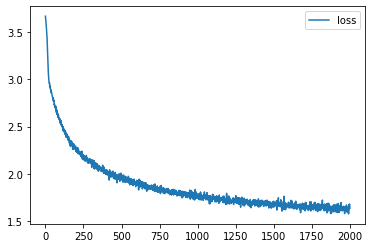

In [64]:
MAX_LENGTH = 200

for i in range(2000):
    batch_ix = to_matrix(text, max_len=MAX_LENGTH, batch_size=32)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    
    logits_seq = rnn_loop(char_rnn.to(device), batch_ix.to(device))
    
    # compute loss
    #
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(
    predictions_logits.reshape((-1, num_tokens)),
    actual_next_tokens.reshape(-1)
    )
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [37]:
def generate_sample(char_rnn, seed_phrase=' Hello '.lower(), max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i].to(device), hid_state.to(device))
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1].to(device), hid_state.to(device))
        p_next = F.softmax(logits_next.cpu() / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        # if next_ix == token_to_id['>']:
        #   break
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [38]:
print(generate_sample(char_rnn, max_length=500, temperature=0.9))

 hello worce that frong theey dea'd,-spefore not hive in cind of bagies have is swade.

  and and kartt no the bate so guin
  decense bunforee in all wherences:
   fart'd wnow's spofte tand, not of dircict rick is proure dislowide,
  confeon tearet miting the roumto i my sowwless of detosinom alfet chass yak besures oc dyat not thy sare, shalt, nubsabe so love to charl'd lovouil thou thou live cordefere you deseld shall doth from by dose blest painter witowes a so mate,
  surwing truv's of lxxii


In [65]:
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'\nTemperature {temp}:')
    print(generate_sample(char_rnn, max_length=500, temperature=temp))


Temperature 0.1:
 hello the sone the shall the stand the shall stand the shall the should the sungurs the stand the stand the self the stand the sone the shall stand the sone the shall the shall the stand the shall shall stand the shall the stand the sungurs the stand the show the stand the stand the will the sungurs the stand the shall the with the shall the shall the sungurs the shall stand the stand the shall the sungurs the shall the stand the stand the shall stand the sungurs the with the stand the stand th

Temperature 0.2:
 hello shall steet the shall strends the for the songer strange the should the show of the sense the stand the sungurs the stand the worth the sunder the show the stranger the thee the stand the stand the stand the with the with the stand the sungurs the stand with all the sunguring the sungurs the with the sungurs the sungurs the stand the sungurs the shall my shall the the strong the praise the should the shall the shall my state the shall the shall so stat

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [57]:
# Your beautiful code here
class CharRNN_LSTMCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=18, rnn_num_units=256, dropout=0.2):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.dropout = nn.Dropout(dropout)
        
        self.rnn_update = nn.LSTM(embedding_size + rnn_num_units, rnn_num_units)
        # self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.dropout(self.embedding(x))
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([x_emb.to(device), h_prev.to(device)], dim=-1) #YOUR CODE HERE
        h_next, _ = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) #YOUR CODE HERE

        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) #YOUR CODE
        
        return h_next, logits
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [58]:
char_lstm = CharRNN_LSTMCell().to(device)
opt = torch.optim.Adam(char_lstm.parameters())
loss_func = nn.CrossEntropyLoss()

history = []

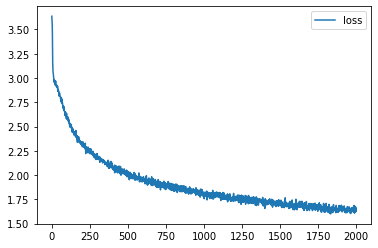

In [61]:
MAX_LENGTH = 200

for i in range(2000):
    batch_ix = to_matrix(text, max_len=MAX_LENGTH, batch_size=32)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_lstm.to(device), batch_ix.to(device))
    
    # compute loss
    #
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = loss_func(predictions_logits.reshape((-1, num_tokens)).to(device),
                     actual_next_tokens.reshape(-1).to(device))
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.item())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [62]:
# Text generation with different temperature values here
for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'\nTemperature {temp}:')
    print(generate_sample(char_lstm, max_length=500, temperature=temp))


Temperature 0.1:
 hello shall the starse the bear thee with the self the stander the say the store the songer the thee are the with the stains the sind the seess the with the sore the with the self the surse the self the beauty the sind the see the say the self the seem the seess the sure the with the sould the see the show the with the sur the state the self the sort the staints the with the surse the with the stand the with the beauty the seem the says the with thee the seess the seest the still the see the wi

Temperature 0.2:
 hello so and beauty the shall and the will the beauty the say in the worth in thee the rost the beauty be the braise the beauty the seed the with the wart the worther the reart the with to show the statee the so doth the conting the seem the shoul the self the sour the still of the ewert that the store the seem the world the prear the doth the sur the seen the love to mour stree the strease the love the surmers shall the the so the strender the beauty the se

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
# Saving and loading code here
PATH = '/content/drive/MyDrive/lstm.pt'
torch.save(char_lstm.state_dict(), PATH)

In [72]:
loaded_model = CharRNN_LSTMCell().to(device)
loaded_model.load_state_dict(torch.load(PATH))
print(generate_sample(loaded_model, seed_phrase='good ', max_length=200, temperature=0.2))

good thee when the beart the with the grow the prouds the worth the sure and the love the praise the love the sursest the with that stare shall the with the such the the seef the with the stands the s


В модели с RNN можно заметить, что при температуре 0.1 и 0.2 сгенерированные отрывки как будто зацикливаются на нескольких словах. 

В модели с LSTM это заметно не так сильно. Самое повторяющееся слово - это `the`. Действительно, в английском языке это самое частое слово в текстах. 

При температуре 0.5 внешне напечатанный отрывок даже напоминает структуру сонета.

Хотя модель и требуеет доработки и более долгого обучения, чеем 2000 эпох, но уже по полученным отрывкам можно сказать, что LSTM, действительно, делает отрывки более поэтичными. А также можно понять, за что отвечает параметр `temperature`.

Так, при больших значениях параметра `temperature` возникает большая энтропия в текстах, они становятся несвязными. Это происходит потому, что логиты, которые выдаёт модель делятся на большое число, а значит, вероятности символов становятся менее различимы и очень близки к друг другу. 

Напротив, если значение `temperature` менее 1, то вероятности символов станут более различимы. Соответственно, текст станет более связным и будет лучше отражать структуру языка в смысле частотности символов.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)